# Census income classification with CATBoost

We want to generate a model that can help us predicting the likelyhood of an individual to earn +50K$ based on census data. In order to do so we will generate similar Gradient Boosting models using estate of the art algorithms such as XGBoost, LightGBM or CATBoost and we will use the shap library to understand this predictions.

In [2]:
# Function to split dataset into training and testing datasets
from sklearn.model_selection import train_test_split


# Confusion matrix
from sklearn.metrics import confusion_matrix

# Shap library
import shap

# Viz and numpy libraries
import matplotlib.pyplot as plt
import numpy as np

# print the JS visualization code to the notebook 
shap.initjs()



In [3]:
# Models
import lightgbm as lgb
import catboost as cat
import xgboost as xgb

## Load dataset

In [13]:
shap.datasets.adult(display = True)

(        Age          Workclass  Education-Num       Marital Status  \
 0      39.0          State-gov           13.0        Never-married   
 1      50.0   Self-emp-not-inc           13.0   Married-civ-spouse   
 2      38.0            Private            9.0             Divorced   
 3      53.0            Private            7.0   Married-civ-spouse   
 4      28.0            Private           13.0   Married-civ-spouse   
 ...     ...                ...            ...                  ...   
 32556  27.0            Private           12.0   Married-civ-spouse   
 32557  40.0            Private            9.0   Married-civ-spouse   
 32558  58.0            Private            9.0              Widowed   
 32559  22.0            Private            9.0        Never-married   
 32560  52.0       Self-emp-inc            9.0   Married-civ-spouse   
 
                Occupation    Relationship    Race      Sex  Capital Gain  \
 0            Adm-clerical   Not-in-family   White     Male        21

We split the dataset into train and test using the numerical features from the adult dataset

In [14]:
X,y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

Each model requires a different input of the data. All their python packages include functions to prepare the data in the appropiate format.

In [4]:
# create a train/test split with lightgbm
d_train_lgb = lgb.Dataset(X_train, label=y_train)
d_test_lgb = lgb.Dataset(X_test, label=y_test)

In [5]:
# create a train/test split with catboost
d_train_cat = cat.Pool(X_train, y_train)
d_test_cat = cat.Pool(X_test, y_test)

In [6]:
# create a train/test split with xgboost
d_train_xgb = xgb.DMatrix(X_train, label=y_train)
d_test_xgb = xgb.DMatrix(X_test, label=y_test)

## Train the model

First we generate a standard average model using CATBoost:

- learning rate: 0.01
- Iterations: 2k with early stopping rounds of 300 
- Default tree depth: 8 levels

We allow a higher learning rate, consequently reducing the number of learning iterations to avoid overfitting and a more limiting early stopping rounds. One of the advantages of using CATBoost is that it provides with an embedded visualization of the training and testing learning curves by the number of iterations, helping to provide with a better understanding of the model.

In [12]:
params = {"iterations": 1500
          , "depth": 8
          , "loss_function": "Logloss"
          , "learning_rate": 0.015
          , "verbose": False}

scores = cat.cv(d_train_cat
            , params
            , fold_count = 4
            , plot = "True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/4]

bestTest = 0.2841200569
bestIteration = 1166

Training on fold [1/4]

bestTest = 0.2702801731
bestIteration = 1360

Training on fold [2/4]

bestTest = 0.287302471
bestIteration = 1160

Training on fold [3/4]

bestTest = 0.2841008674
bestIteration = 1138



In [7]:
model_cat = cat.CatBoostClassifier(iterations = 1160
                                   , learning_rate = 0.015
                                   , loss_function = "Logloss"
                                   , random_seed = 2
                                   , depth = 8)

model_cat.fit(d_train_cat
                , eval_set = d_test_cat
                , verbose_eval=100
                , early_stopping_rounds=50
                , plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6758143	test: 0.6759781	best: 0.6759781 (0)	total: 150ms	remaining: 2m 53s
100:	learn: 0.3154797	test: 0.3213754	best: 0.3213754 (100)	total: 725ms	remaining: 7.6s
200:	learn: 0.2915578	test: 0.2999676	best: 0.2999676 (200)	total: 1.34s	remaining: 6.4s
300:	learn: 0.2816376	test: 0.2927026	best: 0.2927026 (300)	total: 1.92s	remaining: 5.49s
400:	learn: 0.2751440	test: 0.2889560	best: 0.2889560 (400)	total: 2.58s	remaining: 4.88s
500:	learn: 0.2699465	test: 0.2862651	best: 0.2862651 (500)	total: 3.18s	remaining: 4.18s
600:	learn: 0.2655760	test: 0.2843555	best: 0.2843555 (600)	total: 3.76s	remaining: 3.5s
700:	learn: 0.2614430	test: 0.2828689	best: 0.2828689 (700)	total: 4.36s	remaining: 2.85s
800:	learn: 0.2575259	test: 0.2814404	best: 0.2814404 (800)	total: 4.94s	remaining: 2.21s
900:	learn: 0.2538467	test: 0.2798414	best: 0.2798317 (894)	total: 5.53s	remaining: 1.59s
1000:	learn: 0.2506693	test: 0.2790045	best: 0.2789938 (998)	total: 6.13s	remaining: 973ms
1100:	learn: 0.

In [21]:
params = {
    "learning_rate": 0.3,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 20,
}

model_xgb = xgb.train(params
                        , d_train_xgb
                        , 10000
                        , evals = [(d_test_xgb, "Test")]
                        , verbose_eval=1000)

[0]	Test-logloss:0.53710
[1000]	Test-logloss:0.57016
[2000]	Test-logloss:0.64607
[3000]	Test-logloss:0.69346
[4000]	Test-logloss:0.72790
[5000]	Test-logloss:0.75484
[6000]	Test-logloss:0.77654
[7000]	Test-logloss:0.79766
[8000]	Test-logloss:0.81578
[9000]	Test-logloss:0.82836
[9999]	Test-logloss:0.83983


In [22]:
params_lgb = {
    "max_bin": 512,
    "learning_rate": 0.005,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 2,
    "verbose": 1,
    "min_data": 100,
    "boost_from_average": True,
    "max_depth": 8
}

model_lgb = lgb.train(params_lgb
                    , d_train_lgb
                    , 40000
                    , valid_sets = [d_test_lgb]
                    , early_stopping_rounds = 500
                    , verbose_eval = 1000)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6279, number of negative: 19769
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 423
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.241055 -> initscore=-1.146904
[LightGBM] [Info] Start training from score -1.146904
Training until validation scores don't improve for 500 rounds
[1000]	valid_0's binary_logloss: 0.358295
[2000]	valid_0's binary_logloss: 0.331084
[3000]	valid_0's binary_logloss: 0.321767
[4000]	valid_0's binary_logloss: 0.316649
[5000]	valid_0's binary_logloss: 0.312997
[6000]	valid_0's binary_logloss: 0.310121
[7000]	valid_0's binary_logloss: 0.307843
[8000

In [23]:
pred_lgb = model_lgb.predict(X_test, predict_raw_score = False)
pred_xgb = model_xgb.predict(d_test_xgb)
pred_cat = model_cat.predict(X_test)

In [24]:
pred_cat_bool = [True if x == "True" else False for x in pred_cat]
pred_lgb_bool = [True if x >= 0.5 else False for x in pred_lgb]
pred_xgb_bool = [True if x >= 0.5 else False for x in pred_xgb]

In [25]:
print("LightGBM Confusion Matrix")
print(confusion_matrix(y_test, pred_lgb_bool))
print("XGBoost Confusion Matrix")
print(confusion_matrix(y_test, pred_xgb_bool))
print("CATBoost Confusion Matrix")
print(confusion_matrix(y_test, pred_cat_bool))

LightGBM Confusion Matrix
[[4692  259]
 [ 604  958]]
XGBoost Confusion Matrix
[[4480  471]
 [ 564  998]]
CATBoost Confusion Matrix
[[4676  275]
 [ 548 1014]]


## Explain predictions

Here we use the Tree SHAP implementation integrated into all our Gradient Boosting Models to explain the entire dataset (32561 samples).

In [26]:
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [27]:
explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X)

In [28]:
explainer_cat = shap.TreeExplainer(model_cat)
shap_values_cat = explainer_cat.shap_values(X)

### Visualize a single prediction

Note that we use the "display values" data frame so we get nice strings instead of category codes. 

In [29]:
print(X_display.iloc[0,:])
(y_display[0])

Age                         39.0
Workclass              State-gov
Education-Num               13.0
Marital Status     Never-married
Occupation          Adm-clerical
Relationship       Not-in-family
Race                       White
Sex                         Male
Capital Gain              2174.0
Capital Loss                 0.0
Hours per week              40.0
Country            United-States
Name: 0, dtype: object


False

In [31]:
print("XGBoost Shap visualization for instance 0")
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0,:], X_display.iloc[0,:])

XGBoost Shap visualization for instance 0


In [32]:
print("CATBoost Shap visualization for instance 0")
shap.force_plot(explainer_cat.expected_value, shap_values_cat[0,:], X_display.iloc[0,:])

CATBoost Shap visualization for instance 0


### Visualize many predictions

To keep the browser happy we only visualize 1,000 individuals.

In [33]:
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[:1000,:], X_display.iloc[:1000,:])

In [35]:
shap.force_plot(explainer_cat.expected_value, shap_values_cat[:1000,:], X_display.iloc[:1000,:])

## SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

CATBoost


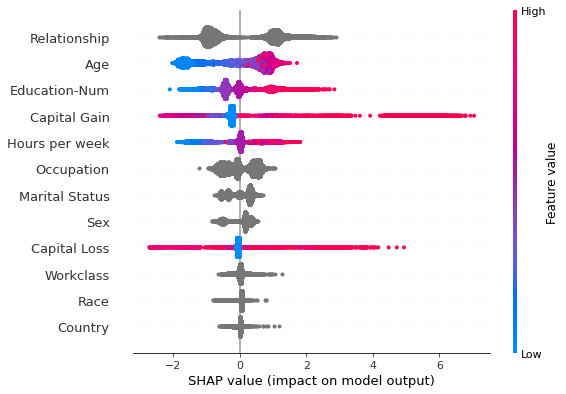

XBoost


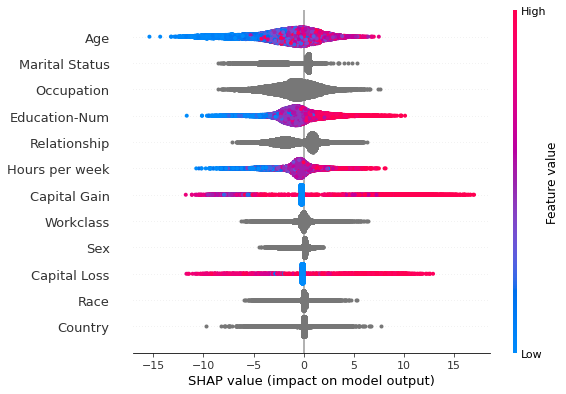

In [36]:
shap_dict = {'model': ['CATBoost', 'XBoost']
             , 'explainer': [explainer_cat, explainer_xgb]
             , 'values': [shap_values_cat, shap_values_xgb]}

for i in range(0,len(shap_dict['model'])):
    print(shap_dict['model'][i])
    shap.summary_plot(shap_dict['values'][i], X_display)

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

XGB


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


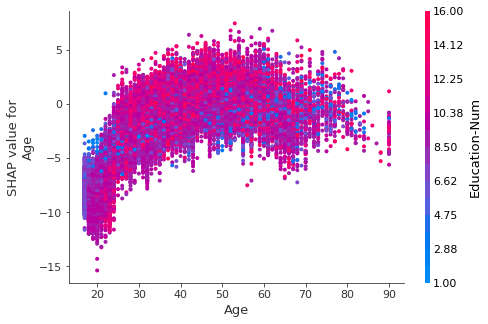

Catboost


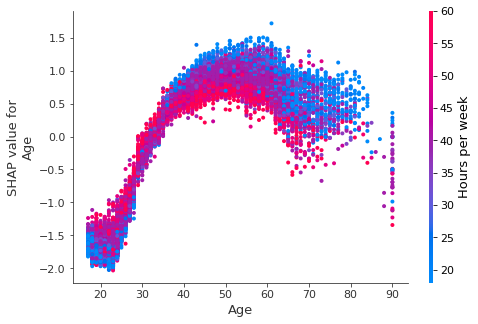

XGB


Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


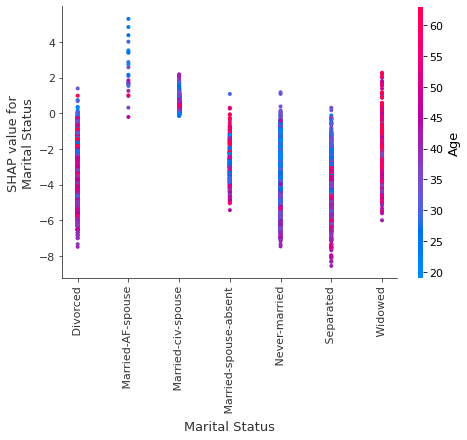

Catboost


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


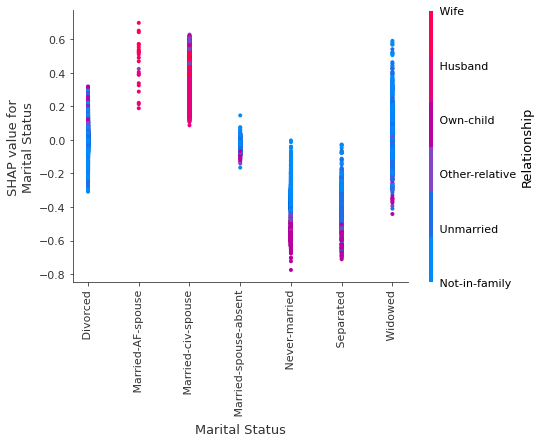

XGB


Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


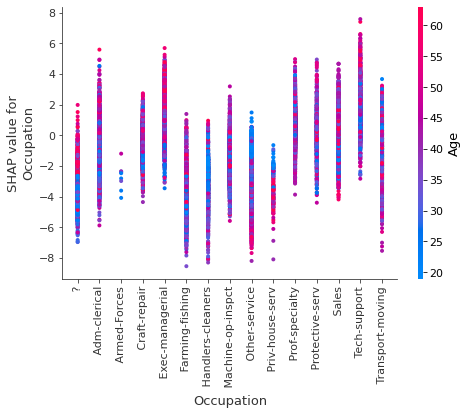

Catboost


Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


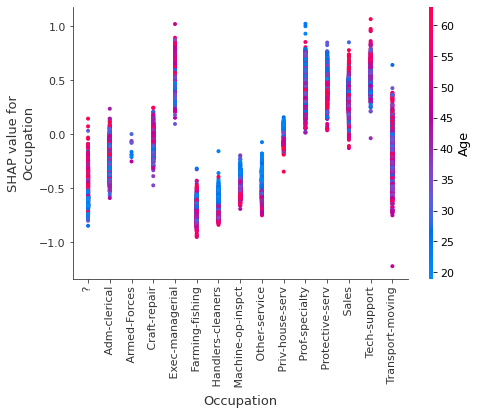

XGB


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


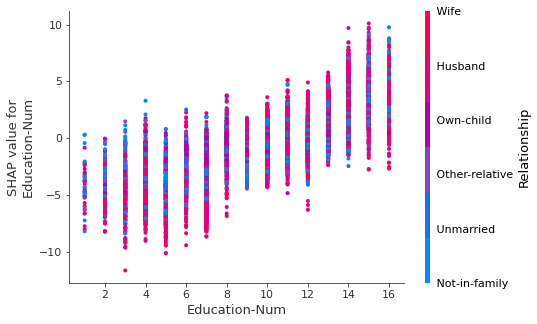

Catboost


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


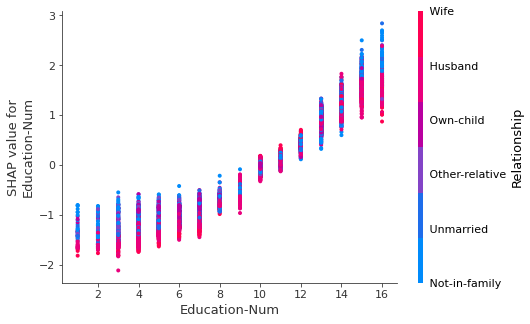

XGB


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


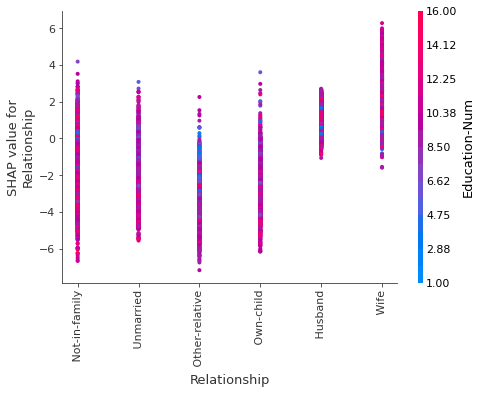

Catboost


Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


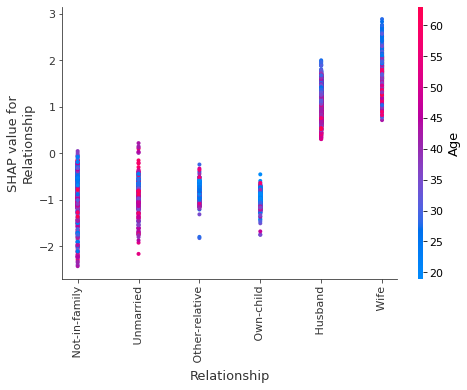

XGB


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


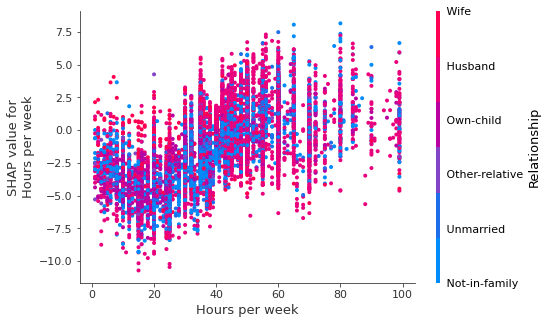

Catboost


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


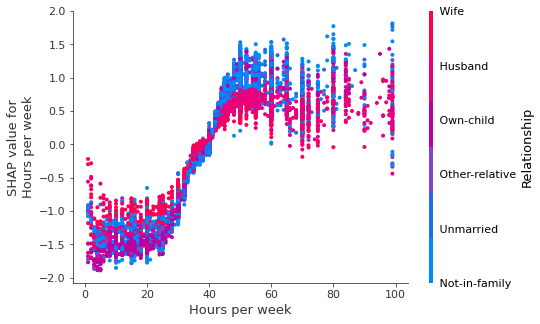

XGB


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


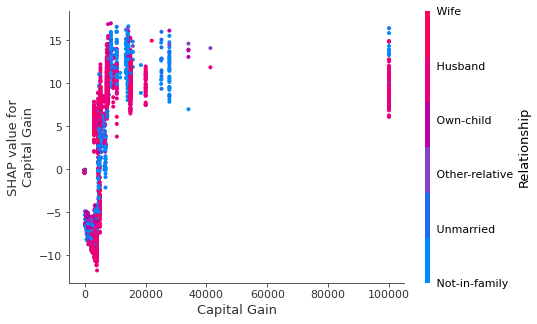

Catboost


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


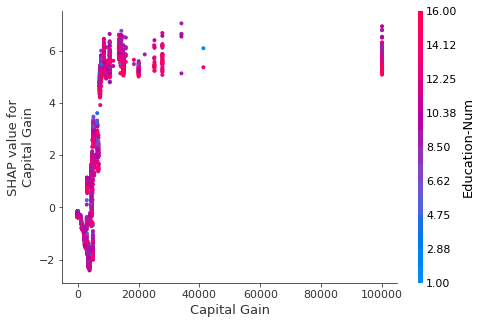

XGB


Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


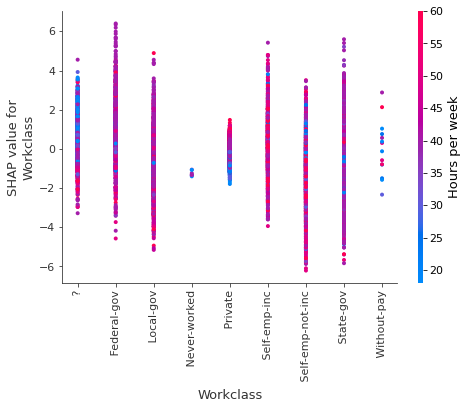

Catboost


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


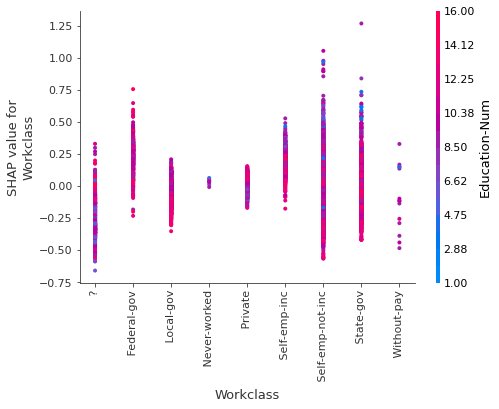

XGB


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


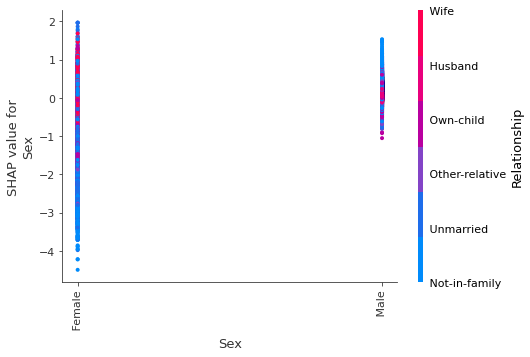

Catboost


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


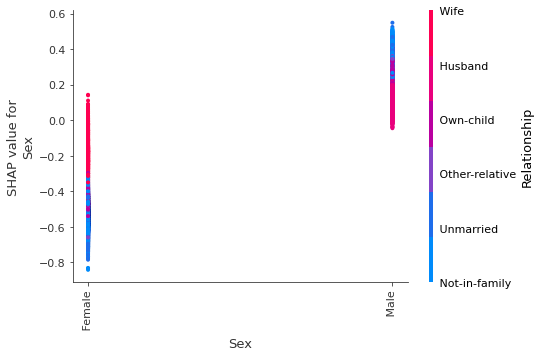

XGB


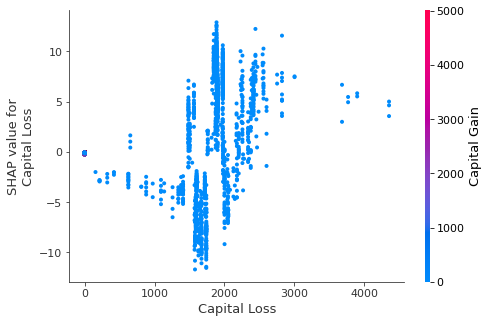

Catboost


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


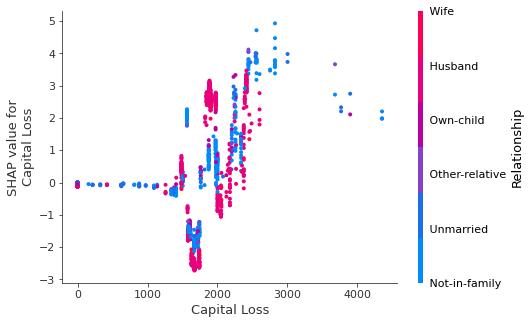

XGB


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


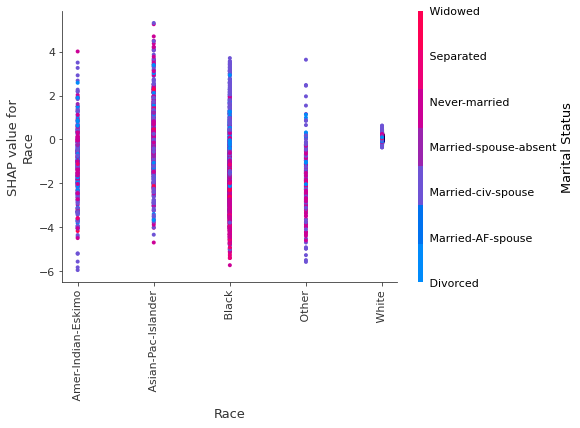

Catboost


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


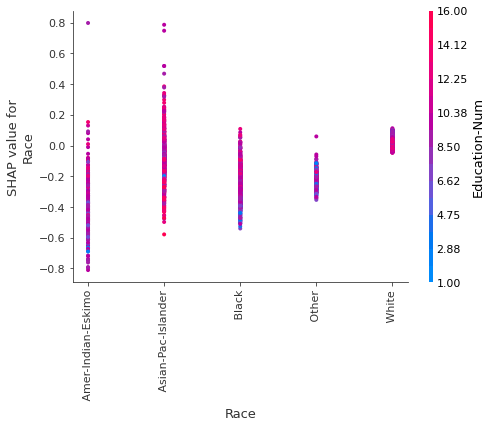

XGB


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


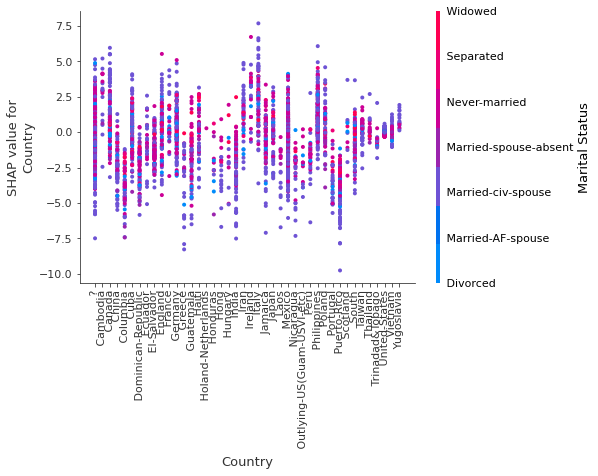

Catboost


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


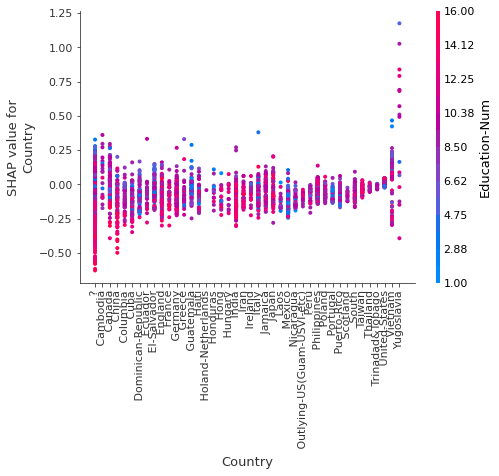

In [37]:
top_inds_xgb = np.argsort(-np.sum(np.abs(shap_values_xgb), 0))
# make SHAP plots of the three most important features
for i in range(0,len(top_inds_xgb)):
    print("XGB")
    shap.dependence_plot(top_inds_xgb[i], shap_values_xgb, X, display_features = X_display)
    print("Catboost")
    shap.dependence_plot(top_inds_xgb[i], shap_values_cat, X, display_features = X_display)

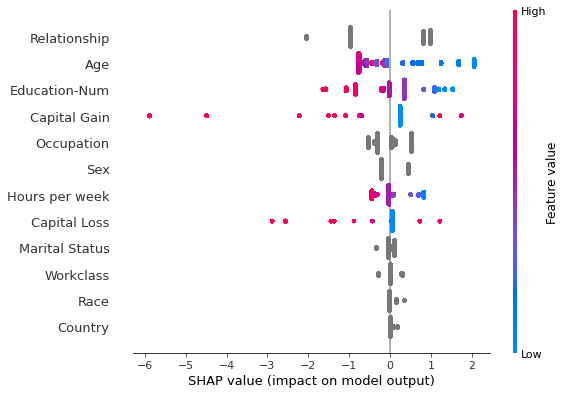

In [46]:
shap.summary_plot(shap_values[0], X_display)